7. ГРАФОВЫЕ НЕЙРОСЕТИ ДЛЯ РЕКОМЕНДАТЕЛЬНЫХ СИСТЕМ

Лекция:  
https://www.youtube.com/watch?v=5HT2lBwRWyA  
Семинар:  
https://www.youtube.com/watch?v=Ng6JKAYpHrE  
Ноутбук к семинару:  
https://disk.yandex.ru/d/CKpJuJyOyV4YBQ  
Конспект notion:  
https://www.notion.so/7-3b8270b607c14a909581ff5a72f18c65  
Конспект pdf:    
https://disk.yandex.ru/i/xmmaZK7cI9inNQ  
Презентация:  
https://disk.yandex.ru/d/nX5upNQj4Mk4yA  

Если вы запускаете данный ноутбук в коллабе с gpu, то выполните следующую ячейку для правильной установки зависимостей

In [1]:
import os

In [2]:
# import torch

# def format_pytorch_version(version):
#     return version.split('+')[0]

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)

# def format_cuda_version(version):
#     return 'cu' + version.replace('.', '')

# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

# !pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install -q torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install -q torch-geometric
# !pip install -q sentence-transformers==2.2.2

In [3]:
# # расскоментируйте код ниже, чтобы установить все зависимости
# !pip install \
#     pyarrow==12.0.1 \
#     polars==0.18.6 \
#     tqdm==4.65.0 \
#     scipy==1.10.1 \
#     scikit-learn==1.3.0 \
#     numpy==1.24.3 \
#     torch==2.0.1 \
#     torch-scatter==2.1.1 \
#     torch-sparse==0.6.17 \
#     torch-cluster==1.6.1 \
#     torch-geometric==2.3.1 \
#     sentence-transformers==2.2.2

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid, MovieLens
from torch_geometric.nn import Node2Vec, SAGEConv, LightGCN, to_hetero
from torch_geometric.data import Data, HeteroData
from torch_geometric.utils import degree
import torch_geometric.transforms as T

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm


# будем использовать cuda, если доступны вычисления на gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

/home/jupyter-pavel.lyubovin/.conda/envs/recsys/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cpu


Мы будем использовать библиотеку `pytorch-geometric`, которая позволяет работать с графовыми структурами данных и предоставляет готовые алгоритмы графовых нейросетей

В качестве структуры данных есть два класса: _Data_ и _HeteroData_

In [5]:
# матрица смежности (пара номеров вершин u и v, между которыми проведены ребра)
edge_index = torch.tensor([[0, 1],
                           [1, 2]], dtype=torch.long)
# в вершины можно записать разные значения, например числа
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.T.contiguous())
# сделаем наши ребра ненаправленные
data = T.ToUndirected()(data)
data.validate(raise_on_error=True)

data.x, data.edge_index

(tensor([[-1.],
         [ 0.],
         [ 1.]]),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]]))

![image](https://pytorch-geometric.readthedocs.io/en/latest/_images/graph.svg)

In [17]:
data = HeteroData().to(device)

n_edges = 1_000
num_papers = 100
num_authors = 500

num_paper_features = num_authors_features = 32

# создадим два типа вершин: paper и author с матрицой признаков
data['paper'].x = torch.randn(num_papers, num_paper_features)
data['author'].x = torch.randn(num_authors, num_authors_features)

# отношение author написал paper сохраним в виде матрицы смежности
data['author', 'writes', 'paper'].edge_index = torch.vstack([
    torch.randint(0, num_papers, (n_edges, ), device=device),
    torch.randint(0, num_authors, (n_edges, ), device=device),
])
# добавим обратные ребра в граф
data = T.ToUndirected()(data)

data

HeteroData(
  paper={ x=[100, 32] },
  author={ x=[500, 32] },
  (author, writes, paper)={ edge_index=[2, 1000] },
  (paper, rev_writes, author)={ edge_index=[2, 1000] }
)

## Node2vec

Node2Vec является вариацией случайного блуждания с параметрами `p` и `q` для контроля глубины блуждания

В данном примере мы рассмотрим датасет [Cora](https://paperswithcode.com/dataset/cora), где представлен граф цитирований статей

![](https://production-media.paperswithcode.com/datasets/Cora-0000000700-ce1c5ec7_LD7pZnT.jpg)

In [25]:
dataset = Planetoid('.', name='Cora')
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [15]:
# 2708 различных статей
# каждая представлена в виде вектора с мешком слов (1433 уникальных)
data.x.shape

torch.Size([2708, 1433])

Epoch: 010, Loss: 4.0655, Acc: 0.2300
Epoch: 020, Loss: 2.1998, Acc: 0.3550
Epoch: 030, Loss: 1.4347, Acc: 0.4580
Epoch: 040, Loss: 1.1129, Acc: 0.5460
Epoch: 050, Loss: 0.9756, Acc: 0.5960
Epoch: 060, Loss: 0.9130, Acc: 0.6340
Epoch: 070, Loss: 0.8804, Acc: 0.6640
Epoch: 080, Loss: 0.8622, Acc: 0.6900
Epoch: 090, Loss: 0.8503, Acc: 0.7040
Epoch: 100, Loss: 0.8436, Acc: 0.7080


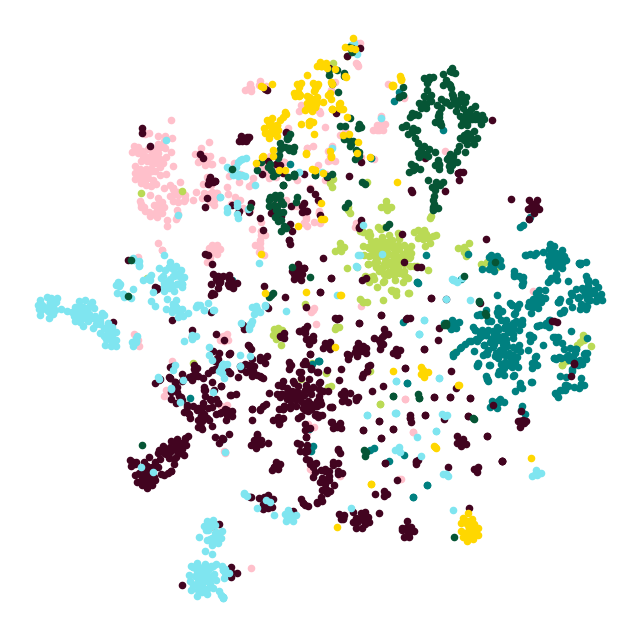

In [7]:
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,  # размер эмбеддинга вершины
    walk_length=20,  # длина случайного блуждания
    context_size=10,  # размер окна из случайного блуждания (как в w2v)
    walks_per_node=10,  # количество случайных блужданий из одной вершины
    num_negative_samples=1,  # количество негативных примеров на один позитивный
    p=1.0,  # параметр вероятности вернуться в предыдущую вершину
    q=1.0,  # параметр вероятности исследовать граф вглубь
    sparse=True,
).to(device)

# класс Node2Vec предоставляет сразу генератор случайного блуждания
loader = model.loader(batch_size=512, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        # pos_rw – последовательность из случайного блуждания
        # neg_rw – случайные негативные примеры
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc


for epoch in range(1, 101):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)

## SAGE

В данном примере мы рассмотрим подход [GraphSAGE](https://paperswithcode.com/method/graphsage) на примере датасета Movielens

![](https://production-media.paperswithcode.com/methods/1b38ceba-a031-474f-a39f-26abc1735e0b.png)

In [17]:
dataset = MovieLens('.', model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

In [18]:
# movie - 9742 фильма, каждый из которых представлен 404-мерным эмбеддингом
# user - 610 человек
# (user, rates, movie)[edge_index] - 2 строки: 1-я юзер, поставивший отметку,
#                                              2 строка - фильм, оцененный этим юзером
# (user, rates, movie)[edge_label] - поставленная оценка от 0 до 5

data

HeteroData(
  movie={ x=[9742, 404] },
  user={ num_nodes=610 },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836]
  }
)

In [61]:
data.metadata()

(['movie', 'user'],
 [('user', 'rates', 'movie'), ('movie', 'rev_rates', 'user')])

In [19]:
# в качестве признаков вершины используем one-hot вектор
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# добавим обратные ребра, чтобы путь в графе мог быть как user -> item, так и item -> user
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label

In [20]:
data

HeteroData(
  movie={ x=[9742, 404] },
  user={ x=[610, 610] },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100836] }
)

In [42]:
use_weighted_loss = True

# в качестве валидации для графов будем случайно выбирать ребра между вершинами
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,  # ?
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

# в датасете много оценок 3 и 4 и мало 0 и 1, поэтому воспользуемся взвешенным
# MSE в качетсве фукнции ошибки
if use_weighted_loss:
    # train_data['user', 'movie'] тоже самое, что и train_data[('user', 'rates', 'movie')]
    weight = torch.bincount(train_data['user', 'movie'].edge_label)
    weight = weight.max() / weight
    # weight == tensor([25.7261,  7.6084,  2.7094,  1.0639,  1.0000,  2.6746])
    # веса для оценок 0, 1, 2, 3, 4, 5 соотвественно
else:
    weight = None


def weighted_mse_loss(pred, target, weight=None):
    # Значит target здесь - это оценки фильма пользователем
    # Также как и pred
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

In [26]:
# Появился новый ключ (user, rates, movie): edge_label_index 
# тоже самое, что и edge_index
# Проверка на тождество:
# (train_data['user', 'movie'].edge_label_index == train_data['user', 'movie'].edge_index).min()

train_data

HeteroData(
  movie={ x=[9742, 404] },
  user={ x=[610, 610] },
  (user, rates, movie)={
    edge_index=[2, 80670],
    edge_label=[80670],
    edge_label_index=[2, 80670]
  },
  (movie, rev_rates, user)={ edge_index=[2, 80670] }
)

In [67]:
train_data.edge_index_dict

{('user',
  'rates',
  'movie'): tensor([[ 297,  181,  473,  ...,  447,  369,  488],
         [2416, 4019,  982,  ..., 7544,  863, 3839]]),
 ('movie',
  'rev_rates',
  'user'): tensor([[2416, 4019,  982,  ..., 7544,  863, 3839],
         [ 297,  181,  473,  ...,  447,  369,  488]])}

In [68]:
train_data.x_dict

{'movie': tensor([[-0.0828,  0.0530,  0.0536,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1053,  0.1508, -0.0264,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0988,  0.0176, -0.0527,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.1115,  0.0310, -0.0177,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0366,  0.0137,  0.0315,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0500, -0.0141, -0.0031,  ...,  0.0000,  0.0000,  0.0000]]),
 'user': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]])}

In [66]:
(train_data['user', 'movie'].edge_label_index == train_data['user', 'movie'].edge_index).min()

tensor(True)

In [12]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        # Что такое z_dict ?
        row, col = edge_label_index
        # Вытягиваем в строку(?) что-то по пользователям, а потом что-то по фильмам
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        # Flatten to 1-dim vector
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [13]:
model = Model(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train():
    model.train()
    optimizer.zero_grad()
    pred = model(
        train_data.x_dict,
        train_data.edge_index_dict,
        train_data['user', 'movie'].edge_label_index
    )
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)


for epoch in range(1, 301):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
            f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

Epoch: 010, Loss: 6.4594, Train: 1.9941, Val: 2.0063, Test: 1.9993
Epoch: 020, Loss: 6.1706, Train: 1.1557, Val: 1.1660, Test: 1.1643
Epoch: 030, Loss: 5.1980, Train: 1.0699, Val: 1.0801, Test: 1.0818
Epoch: 040, Loss: 4.4111, Train: 1.1301, Val: 1.1417, Test: 1.1447
Epoch: 050, Loss: 3.7816, Train: 1.1422, Val: 1.1490, Test: 1.1574
Epoch: 060, Loss: 3.5810, Train: 1.1714, Val: 1.1781, Test: 1.1889
Epoch: 070, Loss: 3.3855, Train: 1.1615, Val: 1.1746, Test: 1.1876
Epoch: 080, Loss: 3.2384, Train: 1.1349, Val: 1.1552, Test: 1.1695
Epoch: 090, Loss: 3.1190, Train: 1.1293, Val: 1.1594, Test: 1.1736
Epoch: 100, Loss: 3.0319, Train: 1.1078, Val: 1.1493, Test: 1.1588
Epoch: 110, Loss: 2.9702, Train: 1.1092, Val: 1.1561, Test: 1.1648
Epoch: 120, Loss: 2.9253, Train: 1.0990, Val: 1.1470, Test: 1.1569
Epoch: 130, Loss: 2.8894, Train: 1.0977, Val: 1.1465, Test: 1.1570
Epoch: 140, Loss: 2.8612, Train: 1.1042, Val: 1.1535, Test: 1.1634
Epoch: 150, Loss: 2.8364, Train: 1.0961, Val: 1.1476, Test: 1.